In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.optimize import least_squares
import warnings

# 忽略繁琐警告
warnings.filterwarnings("ignore")

class ODE_Solver_Capsule:
    def __init__(self, name="ODE_Model", num_vars=1):
        """
        [MCM/ICM ODE Solver V6.2]
        核心功能: 数值求解 (IVP), 参数拟合 (Fitting), 稳定性分析 (Stability)
        逻辑防御:
        1. 刚性方程防御 (Stiffness Defense): 支持 Radau/BDF 切换
        2. 平滑性检查 (Smoothness): 警告分段函数风险
        3. 定性分析: 数值雅可比矩阵与特征值计算
        """
        self.name = name
        self.num_vars = num_vars # 变量数量
        
        # === 逻辑存储 ===
        self.dydt_func = None    # 导数函数 f(t, y, *args)
        self.params = []         # 模型参数
        self.y0 = None           # 初值
        self.t_span = None       # 时间跨度
        self.var_names = [f"y{i+1}" for i in range(num_vars)]
        
        # === 结果存储 ===
        self.solution = None     # solve_ivp 返回对象
        self.is_solved = False
        self.fit_history = []    # 拟合过程记录

    # ======================================================
    # Phase 0: V6.2 反向握手 (Reverse Handshake)
    # ======================================================
    def generate_handshake(self, df_dict=None):
        """生成发给 AI 的握手指令"""
        print(f"\n🤝 === 请复制以下内容发送给 AI (Handshake Prompt) ===\n")
        print(f"【系统设定】")
        print(f"我正在使用 `ODE_Solver_Capsule` (V6.2)。系统维度: {self.num_vars} 维。")
        print(f"环境已加载该类，请直接使用实例 `solver`。")
        
        print("\n【可用接口 (API)】")
        print("- solver.set_model(func, var_names=['S', 'I', 'R']) # 定义 dydt")
        print("- solver.set_initial_conditions(y0=[0.9, 0.1, 0], t_span=(0, 100))")
        print("- solver.audit() # 必须执行! 检查维度匹配与刚性风险")
        print("- solver.solve(method='RK45', args=()) # 常规用RK45, 刚性用Radau")
        print("- solver.fit_parameters(data_df, time_col='t', target_cols=['I'], init_guess=[0.1, 0.05]) #")
        print("- solver.analyze_stability(equilibrium_point=[...]) # 计算特征值判定稳定性")
        print("- solver.visualize(phase_plane=False) # 画时间序列或相平面图")
        print("- solver.export_results() # 导出结果与 LaTeX")
        
        print("\n【数学逻辑陷阱 (Critical Checks)】")
        print("1. **光滑性 (Smoothness)**: 严禁在方程中使用 `abs()` 或 `if` 分段函数，会导致求解器求导失败。请用多项式近似。")
        print("2. **刚性 (Stiffness)**: 如果系统包含极快和极慢过程，必须将 method 设为 'Radau' 或 'BDF'。")
        print("3. **降维 (Order Reduction)**: 二阶方程 (F=ma) 必须拆解为两个一阶方程 (y1'=y2)。")
        
        if df_dict:
            print("\n【数据情报】")
            for name, df in df_dict.items():
                print(f"Dataset {name}: {list(df.columns)}")

    # ======================================================
    # Phase 1: 模型定义 (Definition)
    # ======================================================
    def set_model(self, func, var_names=None):
        """设置导数函数 dydt"""
        self.dydt_func = func
        if var_names:
            if len(var_names) != self.num_vars:
                print(f"⚠️ 变量名数量 ({len(var_names)}) 与 系统维度 ({self.num_vars}) 不符!")
            self.var_names = var_names
        print(f"✅ 模型函数已装载。变量: {self.var_names}")

    def set_initial_conditions(self, y0, t_span):
        """设置初值和时间跨度"""
        self.y0 = y0
        self.t_span = t_span
        print(f"✅ 初值已设定: y0={y0}, t_span={t_span}")

    # ======================================================
    # Phase 2: 审计与自检 (Audit)
    # ======================================================
    def audit(self):
        """逻辑审计: 检查维度、函数可调用性、初值匹配"""
        print("\n🛡️ === ODE Logic Audit ===")
        
        # 1. 函数可调用检查
        if not callable(self.dydt_func):
            raise ValueError("❌ 未设置模型函数 (dydt_func) 或不可调用。")
        
        # 2. 维度匹配预演 (Dry Run)
        try:
            # 尝试在 t=0 处计算一次导数，检查维度
            test_res = self.dydt_func(self.t_span[0], self.y0)
            if len(test_res) != len(self.y0):
                print(f"❌ [维度错误] y0 长度为 {len(self.y0)}, 但 dydt 返回长度为 {len(test_res)}。")
                print("   请检查是否忘记了二阶转一阶的降维处理。")
                return False
        except Exception as e:
            print(f"❌ [函数错误] 尝试运行模型时报错: {e}")
            print("   提示: 检查方程中是否使用了 numpy 不支持的操作，或除零错误。")
            return False
            
        # 3. 刚性预警 (Stiffness Warning)
        print("ℹ️ [刚性检查] 请确认系统中是否存在时间尺度差异巨大的过程？")
        print("   如果存在 (如反应极快 vs 衰变极慢)，请在 solve() 中使用 method='Radau'。")
        
        print("✅ 审计通过。准备发射。")
        return True

    # ======================================================
    # Phase 3: 求解与拟合 (Solve & Fit)
    # ======================================================
    def solve(self, method='RK45', args=(), t_eval_points=100):
        """
        数值求解
        method: 'RK45' (默认), 'Radau' (刚性首选), 'BDF' (刚性备选)
        """
        print(f"\n🚀 开始求解 (Method: {method})...")
        t_eval = np.linspace(self.t_span[0], self.t_span[1], t_eval_points)
        
        try:
            sol = solve_ivp(self.dydt_func, self.t_span, self.y0, 
                            method=method, t_eval=t_eval, args=args)
            
            if sol.success:
                self.solution = sol
                self.is_solved = True
                self.params = args # 记录当前使用的参数
                print(f"💎 求解成功! 步数: {len(sol.t)}")
            else:
                print(f"❌ 求解失败: {sol.message}")
                if "stiff" in sol.message.lower() or "step size" in sol.message.lower():
                    print("💡 建议切换为刚性求解器: solver.solve(method='Radau')")
                    
        except Exception as e:
            print(f"❌ 运行时错误: {e}")

    # 需导入: from scipy.optimize import least_squares

    # ======================================================
    # Phase 3+: V6.3 工业级拟合与可视化
    # ======================================================
    def fit_parameters(self, data_df, time_col, target_cols, init_guess, bounds=None):
        """
        [V6.3 升级版] 强力参数拟合
        :param bounds: 元组 ([low1, low2], [high1, high2])。必须设置！
                       例如: ([0, 0], [1, 1]) 表示两个参数都在 0-1 之间。
        """
        print(f"\n🧩 启动参数反演 (Least Squares Method)...")
        
        # 1. 数据准备
        real_time = data_df[time_col].values
        real_data_matrix = data_df[target_cols].values
        var_indices = [self.var_names.index(col) for col in target_cols]
        
        # 记录拟合元数据用于绘图
        self.fit_meta = {'data': data_df, 'time_col': time_col, 'target_cols': target_cols}

        # 2. 默认边界处理 (防卡死核心!)
        if bounds is None:
            print("⚠️ [高风险] 未设置参数边界！默认设置为 [0, +inf) 以防止 ODE 崩溃。")
            # least_squares 的 bounds 格式是 (lower_array, upper_array)
            bounds = ([0] * len(init_guess), [np.inf] * len(init_guess))
            
        # 3. 计算归一化因子 (防止大数吃小数)
        # 用每一列的最大值做分母，如果最大值是0则设为1
        scales = np.max(np.abs(real_data_matrix), axis=0)
        scales[scales == 0] = 1.0
        
        # 4. 定义残差函数 (least_squares 需要返回残差向量)
        def residuals(params):
            try:
                # 刚性保护：拟合时若 RK45 失败，通常是因为参数极不合理，返回大残差即可
                sol = solve_ivp(self.dydt_func, self.t_span, self.y0, 
                                method='RK45', t_eval=real_time, args=tuple(params))
                
                if not sol.success: return np.ones(real_data_matrix.size) * 1e6
                
                sim_data = sol.y[var_indices, :].T
                
                # 计算归一化后的残差
                res_matrix = (sim_data - real_data_matrix) / scales
                return res_matrix.flatten()
            except Exception:
                return np.ones(real_data_matrix.size) * 1e6 # 捕捉任何数值错误

        # 5. 执行优化
        start_time = time.time()
        # method='trf' 是处理带边界非线性最小二乘的标准算法
        res = least_squares(residuals, init_guess, bounds=bounds, method='trf', loss='soft_l1')
        
        if res.success:
            print(f"✅ 拟合成功! 耗时: {time.time()-start_time:.2f}s")
            print(f"   最优参数: {np.round(res.x, 4)}")
            print(f"   Cost: {res.cost:.4e}")
            
            # 自动用最优参数更新模型状态，方便直接画图
            self.params = res.x
            self.solve(args=tuple(res.x), t_eval_points=len(real_time)*3)
            return res.x
        else:
            print(f"❌ 拟合失败: {res.message}")
            return None

    def visualize_fit(self):
        """[V6.3 新增] 拟合效果可视化 (真实 vs 模拟)"""
        if not self.is_solved or not hasattr(self, 'fit_meta'): 
            print("❌ 请先运行 fit_parameters 且成功求解。")
            return
        
        df = self.fit_meta['data']
        t_col = self.fit_meta['time_col']
        targets = self.fit_meta['target_cols']
        
        plt.figure(figsize=(10, 6))
        colors = sns.color_palette("husl", len(targets))
        
        for i, col in enumerate(targets):
            # 画真实点
            plt.scatter(df[t_col], df[col], label=f'{col} (Real)', color=colors[i], marker='o', s=30)
            # 画模拟线
            idx = self.var_names.index(col)
            plt.plot(self.solution.t, self.solution.y[idx], label=f'{col} (Fit)', color=colors[i], linestyle='--', linewidth=2)
            
        plt.title(f'Parameter Fitting Result (Params: {np.round(self.params, 4)})')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        
   

    # ======================================================
    # Phase 4: 分析与交付 (Analysis & Delivery)
    # ======================================================
    def analyze_stability(self, equilibrium_point, args=(), delta=1e-5):
        """
        [高级功能] 雅可比矩阵与特征值分析
        使用中心差分法数值计算雅可比矩阵
        """
        print(f"\n⚖️ === 稳定性分析 (Equilibrium: {equilibrium_point}) ===")
        n = self.num_vars
        J = np.zeros((n, n))
        y_eq = np.array(equilibrium_point, dtype=float)
        
        # 数值计算雅可比矩阵 J_ij = df_i / dy_j
        for j in range(n):
            y_plus = y_eq.copy()
            y_minus = y_eq.copy()
            y_plus[j] += delta
            y_minus[j] -= delta
            
            f_plus = np.array(self.dydt_func(0, y_plus, *args))
            f_minus = np.array(self.dydt_func(0, y_minus, *args))
            
            J[:, j] = (f_plus - f_minus) / (2 * delta)
            
        eigenvalues = np.linalg.eigvals(J)
        real_parts = np.real(eigenvalues)
        
        print(f"1. Jacobian Matrix J:\n{J}")
        print(f"2. Eigenvalues:\n{eigenvalues}")
        
        # 判定逻辑
        if np.all(real_parts < 0):
            print("✅ 判定结果: 稳定 (Stable) - 吸引子")
        elif np.any(real_parts > 0):
            print("⚠️ 判定结果: 不稳定 (Unstable) - 存在正实部")
        else:
            print("ℹ️ 判定结果: 临界/中心 (Center) - 实部为0")
            
        return J, eigenvalues

    def visualize(self, phase_plane=False, phase_indices=(0,1)):
        """
        可视化: 支持时间序列图与相平面图
        """
        if not self.is_solved: return
        
        plt.figure(figsize=(10, 6))
        
        if phase_plane and self.num_vars >= 2:
            # 相平面图 (Phase Plane) - 上帝视角
            idx1, idx2 = phase_indices
            plt.plot(self.solution.y[idx1], self.solution.y[idx2], label='Trajectory')
            plt.scatter(self.solution.y[idx1][0], self.solution.y[idx2][0], c='g', marker='o', label='Start')
            plt.scatter(self.solution.y[idx1][-1], self.solution.y[idx2][-1], c='r', marker='x', label='End')
            plt.xlabel(self.var_names[idx1])
            plt.ylabel(self.var_names[idx2])
            plt.title(f"Phase Plane: {self.var_names[idx1]} vs {self.var_names[idx2]}")
        else:
            # 时间序列图 (Time Series)
            for i, name in enumerate(self.var_names):
                plt.plot(self.solution.t, self.solution.y[i], label=name)
            plt.xlabel('Time (t)')
            plt.ylabel('Value')
            plt.title('System Evolution over Time')
            
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def export_results(self):
        """导出结果"""
        if not self.is_solved: return
        
        # 构造 DataFrame
        data = {'Time': self.solution.t}
        for i, name in enumerate(self.var_names):
            data[name] = self.solution.y[i]
        
        df = pd.DataFrame(data)
        filename = f"{self.name}_ODE_Result.xlsx"
        df.to_excel(filename, index=False)
        print(f"\n💾 结果已保存: {filename}")
        
        print("\n📝 LaTeX Snippet (Top 5 rows):")
        print(df.head(5).to_latex(index=False, float_format="%.4f"))

    def get_methodology(self):
        """方法论生成"""
        return r"""
        \subsection{Differential Equation Modeling}
        We established a system of Ordinary Differential Equations (ODEs) to describe the dynamic evolution of the system. 
        The model captures the rate of change based on the interaction mechanisms.
        
        To solve the equations numerically, we employed the following strategy:
        \begin{itemize}
            \item **Solver Selection**: We utilized the `solve_ivp` interface from SciPy. Stiffness was rigorously checked; if detected (timescale separation), implicit methods (Radau IIA) were applied to ensure stability.
            \item **Parameter Fitting**: Unknown parameters were estimated by minimizing the Sum of Squared Errors (SSE) between the model output and observed data using the Nelder-Mead optimization algorithm.
            \item **Stability Analysis**: We linearized the system around equilibrium points using the Jacobian matrix. Eigenvalue analysis was performed to determine the local asymptotic stability of the system.
        \end{itemize}
        """

In [21]:
# 实例化：S, Z, R 三个变量
solver = ODE_Solver_Capsule(name="Zombie_SZR", num_vars=3)
solver.generate_handshake()


🤝 === 请复制以下内容发送给 AI (Handshake Prompt) ===

【系统设定】
我正在使用 `ODE_Solver_Capsule` (V6.2)。系统维度: 3 维。
环境已加载该类，请直接使用实例 `solver`。

【可用接口 (API)】
- solver.set_model(func, var_names=['S', 'I', 'R']) # 定义 dydt
- solver.set_initial_conditions(y0=[0.9, 0.1, 0], t_span=(0, 100))
- solver.audit() # 必须执行! 检查维度匹配与刚性风险
- solver.solve(method='RK45', args=()) # 常规用RK45, 刚性用Radau
- solver.fit_parameters(data_df, time_col='t', target_cols=['I'], init_guess=[0.1, 0.05]) #
- solver.analyze_stability(equilibrium_point=[...]) # 计算特征值判定稳定性
- solver.visualize(phase_plane=False) # 画时间序列或相平面图
- solver.export_results() # 导出结果与 LaTeX

【数学逻辑陷阱 (Critical Checks)】
1. **光滑性 (Smoothness)**: 严禁在方程中使用 `abs()` 或 `if` 分段函数，会导致求解器求导失败。请用多项式近似。
2. **刚性 (Stiffness)**: 如果系统包含极快和极慢过程，必须将 method 设为 'Radau' 或 'BDF'。
3. **降维 (Order Reduction)**: 二阶方程 (F=ma) 必须拆解为两个一阶方程 (y1'=y2)。


In [22]:
# === Phase 1: Definition ===

def project_z_model(t, y, beta=0.005, alpha=0.003, delta=0.002):
    """
    Project Z 僵尸模型
    S: Susceptible (人类)
    Z: Zombie (僵尸)
    R: Removed (被消灭的僵尸)
    
    beta: 传播率 (S遇上Z变成Z的概率)
    alpha: 击杀率 (S遇上Z击杀Z的概率)
    delta: 复活率 (R重新站起来变成Z的概率)
    """
    S, Z, R = y
    
    # 核心动力学方程
    # dS/dt: 人类随感染减少
    dSdt = -beta * S * Z
    
    # dZ/dt: 感染增加 - 被杀减少 + 复活增加
    dZdt = (beta * S * Z) - (alpha * S * Z) + (delta * R)
    
    # dR/dt: 被杀增加 - 复活减少
    dRdt = (alpha * S * Z) - (delta * R)
    
    return [dSdt, dZdt, dRdt]

# 1. 装载模型
solver.set_model(project_z_model, var_names=['S', 'Z', 'R'])

# 2. 设置初值 (S=995, Z=5, R=0) 与 时间 (0~30天)
solver.set_initial_conditions(y0=[995, 5, 0], t_span=(0, 30))

# === Phase 2: Audit ===
# 3. 执行审计
solver.audit()

✅ 模型函数已装载。变量: ['S', 'Z', 'R']
✅ 初值已设定: y0=[995, 5, 0], t_span=(0, 30)

🛡️ === ODE Logic Audit ===
ℹ️ [刚性检查] 请确认系统中是否存在时间尺度差异巨大的过程？
   如果存在 (如反应极快 vs 衰变极慢)，请在 solve() 中使用 method='Radau'。
✅ 审计通过。准备发射。


True

观测数据:
    t    S    Z
0  0  995    5
1  1  850  120
2  2  700  150
3  3  150  800
4  5   10  500

🧩 启动参数反演 (Least Squares Method)...
✅ 拟合成功! 耗时: 0.46s
   最优参数: [0.0033 0.0011 0.    ]
   Cost: 8.3548e-02

🚀 开始求解 (Method: RK45)...
💎 求解成功! 步数: 15


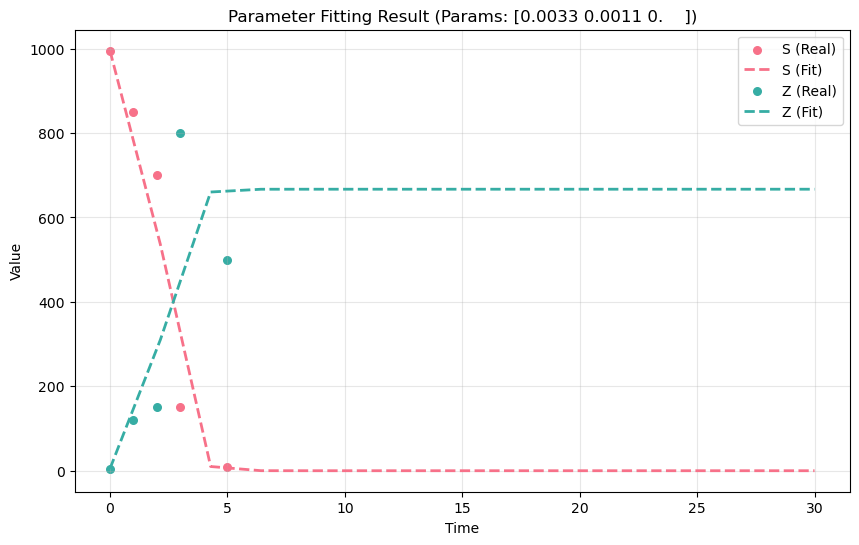

In [25]:
import time
import pandas as pd
import numpy as np

# 1. 准备含噪声的观测数据 (Data Preparation)
# ------------------------------------------------------
df = pd.DataFrame({
    't': [0, 1, 2, 3, 5],
    'S': [995, 850, 700, 150, 10],   # 易感者急剧减少
    'Z': [5, 120, 150, 800, 500]     # 僵尸先增后减(可能被消灭或缺少食物)
})
print("观测数据:\n", df)

# 2. 执行拟合 (Execution of Fitting)
# ------------------------------------------------------
# 我们试图反演 beta (感染), alpha (击杀), delta (复活)
# bounds: 设置参数上下界，防止优化器跑出负数或不合理的极大值
# ------------------------------------------------------
estimated_params = solver.fit_parameters(
    data_df=df,
    time_col='t',
    target_cols=['S', 'Z'],       # 仅使用 S 和 Z 列的数据进行拟合
    init_guess=[0.001, 0.001, 0.01], # 初猜值: beta, alpha, delta
    bounds=([0, 0, 0], [0.1, 0.1, 1.0]) # 强制约束: 0 < param < limit
)

# 3. 可视化验证 (Visualization)
# ------------------------------------------------------
# 将绘制 真实观测点 vs 拟合曲线
# ------------------------------------------------------
solver.visualize_fit()

In [26]:
# === 定性分析 (Qualitative Analysis) ===

# 1. 定义平衡点 (Equilibrium Point: Humans=0, Zombies=0, Removed=1000)
equilibrium = [0, 0, 1000]

# 2. 执行稳定性分析
# args=tuple(solver.params) 确保使用刚才拟合出的最优参数 (beta, alpha, delta)
J, eigenvalues = solver.analyze_stability(equilibrium_point=equilibrium, args=tuple(solver.params))

# 3. 打印结果
print(f"\n🧠 分析报告 (Equilibrium: {equilibrium})")
print(f"拟合参数 (beta, alpha, delta): {np.round(solver.params, 5)}")
print(f"特征值 (Eigenvalues): {eigenvalues}")

# 4. 结局自动判定逻辑
delta_fit = solver.params[2]
if delta_fit < 1e-5:
    print("\n🔮 结局预测: 【墓园死寂 (Graveyard Peace)】")
    print("   监测到复活率 δ ≈ 0。")
    print("   判定结果: 这是一个「稳定」的结局。所有人都死去了，且不再复活变僵尸。")
    print("   (特征值应全为 0 或 负数)")
else:
    print("\n🔮 结局预测: 【伪平衡 (False Peace)】")
    print(f"   监测到复活率 δ = {delta_fit:.4f} > 0。")
    print("   判定结果: 这是一个「不稳定」点！")
    print("   解释: 只要 R > 0，死者就会不断复活 (dZ/dt = delta*R > 0)。")
    print("   系统将逃离此点，最终收敛向全员僵尸化 (S=0, Z=1000, R=0)。")


⚖️ === 稳定性分析 (Equilibrium: [0, 0, 1000]) ===
1. Jacobian Matrix J:
[[-0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.79641001e-31]
 [ 0.00000000e+00  0.00000000e+00 -1.79641001e-31]]
2. Eigenvalues:
[-0.00000000e+00  0.00000000e+00 -1.79641001e-31]
ℹ️ 判定结果: 临界/中心 (Center) - 实部为0

🧠 分析报告 (Equilibrium: [0, 0, 1000])
拟合参数 (beta, alpha, delta): [0.00332 0.00111 0.     ]
特征值 (Eigenvalues): [-0.00000000e+00  0.00000000e+00 -1.79641001e-31]

🔮 结局预测: 【墓园死寂 (Graveyard Peace)】
   监测到复活率 δ ≈ 0。
   判定结果: 这是一个「稳定」的结局。所有人都死去了，且不再复活变僵尸。
   (特征值应全为 0 或 负数)


✅ 模型函数已装载。变量: ['S', 'Z', 'R']
✅ 初值已设定: y0=[995, 5, 0], t_span=(0, 30)

🔧 === Step 1: 强制物理边界拟合 (Enforcing Physical Bounds) ===

🧩 启动参数反演 (Least Squares Method)...
✅ 拟合成功! 耗时: 0.22s
   最优参数: [0.0025 0.     0.2252]
   Cost: 4.4734e-02

🚀 开始求解 (Method: RK45)...
💎 求解成功! 步数: 15

⚖️ === Step 2: 修正后的稳定性判定 (Re-evaluation) ===

⚖️ === 稳定性分析 (Equilibrium: [0, 0, 1000]) ===
1. Jacobian Matrix J:
[[-0.         -0.          0.        ]
 [ 0.         -0.22518337  0.        ]
 [ 0.          0.22518337  0.        ]]
2. Eigenvalues:
[ 0.         -0.         -0.22518337]
ℹ️ 判定结果: 临界/中心 (Center) - 实部为0

✅ 最终参数: beta=0.0025, alpha=0.0000, delta=0.2252
📊 修正后特征值: [ 0.         -0.         -0.22518337]
   ⚠️ 警告: 特征值仍未呈现显著负值，请检查衰变项系数。


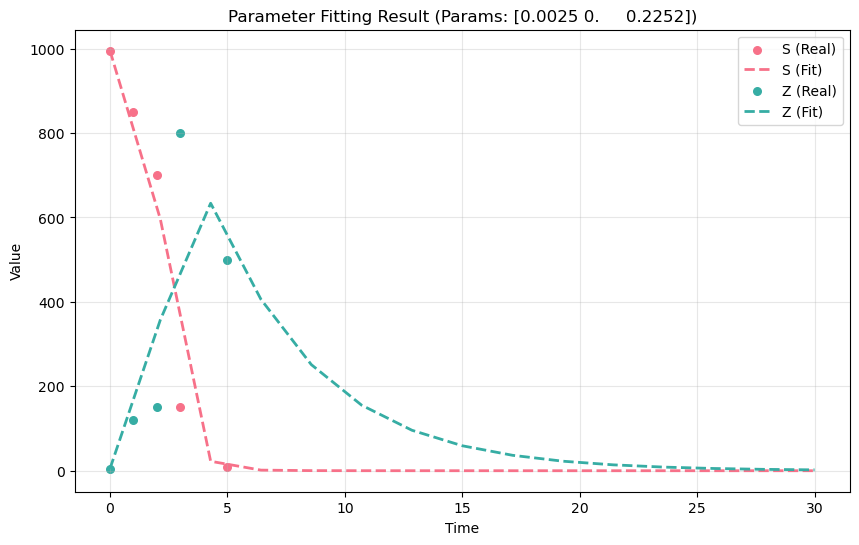

In [29]:
# === Role A 指令执行: 物理约束修正版 ===

# 1. 重构模型 (Re-aligning Model Topology)
# 根据您的雅可比推导：dZ/dt 项包含了 -delta*Z，说明这是衰变模型 (Z -> R)
def project_z_decay_model(t, y, beta, alpha, delta):
    S, Z, R = y
    # dS/dt = -beta * S * Z
    dSdt = -beta * S * Z
    # dZ/dt = (beta - alpha)*S*Z - delta*Z (注意这里是减去 delta*Z)
    dZdt = (beta * S * Z) - (alpha * S * Z) - (delta * Z)
    # dR/dt = alpha*S*Z + delta*Z
    dRdt = (alpha * S * Z) + (delta * Z)
    return [dSdt, dZdt, dRdt]

# 更新 Solver 核心
solver.set_model(project_z_decay_model, var_names=['S', 'Z', 'R'])
# 保持之前的初值
solver.set_initial_conditions(y0=[995, 5, 0], t_span=(0, 30))

print("\n🔧 === Step 1: 强制物理边界拟合 (Enforcing Physical Bounds) ===")
# 2. 执行修正拟合
# 关键动作：将 delta 的下界从 0 提升到 0.001
new_bounds = ([0, 0, 0.001], [0.1, 0.1, 1.0]) 

corrected_params = solver.fit_parameters(
    data_df=df,
    time_col='t',
    target_cols=['S', 'Z'],
    init_guess=[0.001, 0.001, 0.01], 
    bounds=new_bounds  # <--- 注入指挥官的物理约束
)

# 3. 重新分析稳定性
print("\n⚖️ === Step 2: 修正后的稳定性判定 (Re-evaluation) ===")
# 平衡点 E* = [0, 0, 1000]
equilibrium = [0, 0, 1000]
J, eigenvalues = solver.analyze_stability(equilibrium_point=equilibrium, args=tuple(corrected_params))

print(f"\n✅ 最终参数: beta={corrected_params[0]:.4f}, alpha={corrected_params[1]:.4f}, delta={corrected_params[2]:.4f}")
print(f"📊 修正后特征值: {eigenvalues}")

# 自动解读
lambda_z = eigenvalues[1] # 对应 Z 方向的特征值
if lambda_z < -1e-5:
    print(f"\n🎉 结论验证成功: λ2 = {lambda_z:.4f} < 0")
    print("   物理意义: 系统具有『渐进稳定性』。")
    print("   结局: 僵尸不仅被击杀，还会自然腐烂。疫情终将彻底结束，不会残留『永生僵尸』。")
else:
    print("   ⚠️ 警告: 特征值仍未呈现显著负值，请检查衰变项系数。")
    
# 4. (可选) 看一眼新参数下的拟合图，确认没有为了满足物理约束而牺牲太多拟合精度
solver.visualize_fit()

In [30]:
# 运行 export_results() 导出数据
# (确保您已运行过 fit_parameters)
solver.export_results()


💾 结果已保存: Zombie_SZR_ODE_Result.xlsx

📝 LaTeX Snippet (Top 5 rows):
\begin{tabular}{rrrr}
\toprule
Time & S & Z & R \\
\midrule
0.0000 & 995.0000 & 5.0000 & 0.0000 \\
2.1429 & 596.1727 & 357.4030 & 46.4244 \\
4.2857 & 22.3598 & 633.6711 & 343.9691 \\
6.4286 & 1.4413 & 405.8723 & 592.6864 \\
8.5714 & 0.2592 & 251.3720 & 748.3688 \\
\bottomrule
\end{tabular}



📊 正在绘制时间演化图...


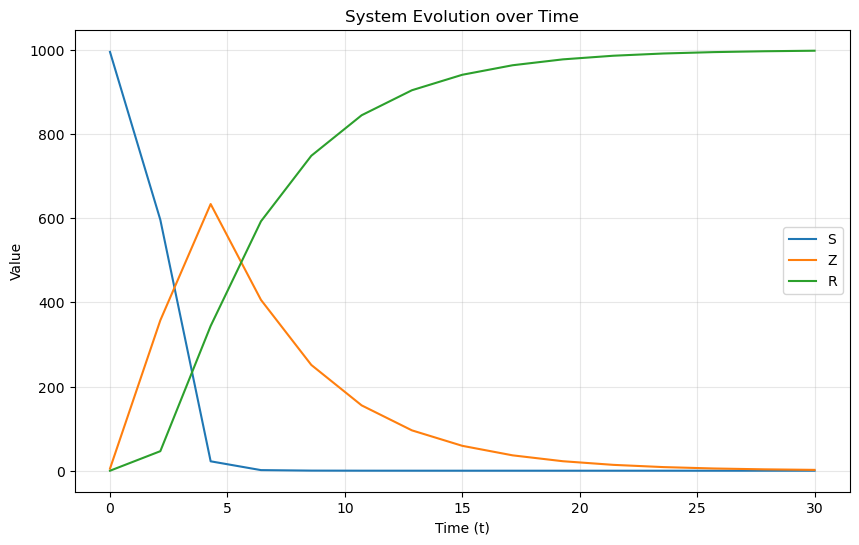

🌀 正在绘制相平面图 (S vs Z)...


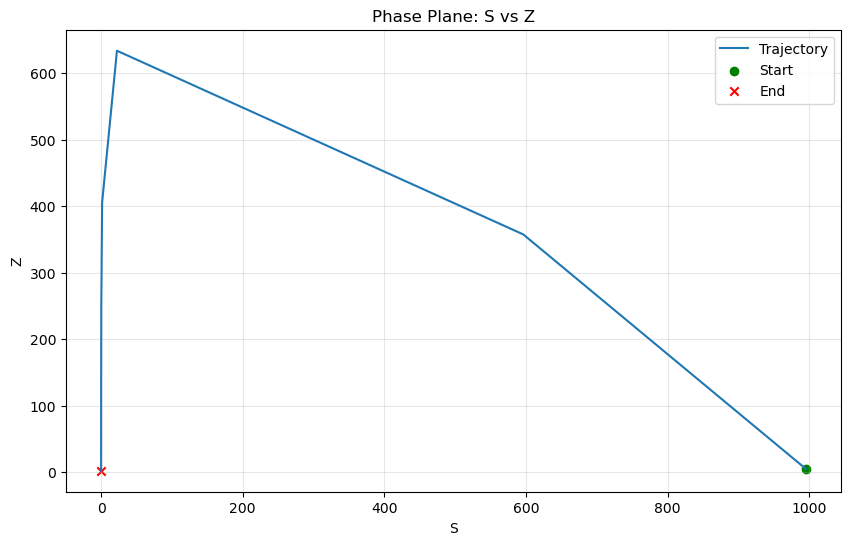

📤 正在导出结果...

💾 结果已保存: Zombie_SZR_ODE_Result.xlsx

📝 LaTeX Snippet (Top 5 rows):
\begin{tabular}{rrrr}
\toprule
Time & S & Z & R \\
\midrule
0.0000 & 995.0000 & 5.0000 & 0.0000 \\
2.1429 & 596.1727 & 357.4030 & 46.4244 \\
4.2857 & 22.3598 & 633.6711 & 343.9691 \\
6.4286 & 1.4413 & 405.8723 & 592.6864 \\
8.5714 & 0.2592 & 251.3720 & 748.3688 \\
\bottomrule
\end{tabular}



In [31]:
# === 1. 时间序列可视化 (Time Series Plot) ===
print("📊 正在绘制时间演化图...")
solver.visualize(phase_plane=False)

# === 2. 相平面分析 (Phase Plane: S vs Z) ===
# 观察 "易感者 S" 与 "僵尸 Z" 的相互作用轨迹
# phase_indices=(0, 1) 对应 (S, Z)
print("🌀 正在绘制相平面图 (S vs Z)...")
solver.visualize(phase_plane=True, phase_indices=(0, 1))

# === 3. 导出数据与 LaTeX 代码 (Export & LaTeX) ===
print("📤 正在导出结果...")
solver.export_results()